In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ECE1786_dataset/

Mounted at /content/drive
/content/drive/MyDrive/ECE1786_dataset


In [2]:
!ls

checkpoints
final_dataset_suicide.csv
final_dataset_suicide_test_10_openai.csv
final_dataset_suicide_test_10_openai_prepared.jsonl
final_dataset_suicide_test.csv
final_dataset_suicide_test_huggingface.csv
final_dataset_suicide_test_openai.csv
final_dataset_suicide_test_openai_prepared.jsonl
final_dataset_suicide_train_10_openai.csv
final_dataset_suicide_train_10_openai_prepared.jsonl
final_dataset_suicide_train.csv
final_dataset_suicide_train_huggingface.csv
final_dataset_suicide_train_openai.csv
final_dataset_suicide_train_openai_prepared.jsonl
my_gpt2
openai_apikey.txt
safechat-gpt2
wandb


In [3]:
!pip install transformers
!pip install openai
!pip install ml-things
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.8 MB/s 
     |████████████████████████████████| 7.6 MB 1.4 MB/s 
     |████████████████████████████████| 182 kB 73.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 44 kB 1.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 146 kB 9.1 MB/s 
  Created wheel for openai: filename=openai-0.25.0-py3-none-any.whl size=55880 sha256=dbe2ddc4eb5ff4bc35cf1be25a541c242df75e506c568609d4d527796abb8814
  Stored in directory: /root/.cache/pip/wheels/4b/92/33/6f57c7aae0b16875267999a50570e81f15eecec577ebe05a2e
Successfully built openai
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██

Found existing installation: matplotlib 3.6.2
Uninstalling matplotlib-3.6.2:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/matplotlib-3.6.2-py3.8-nspkg.pth
    /usr/local/lib/python3.8/dist-packages/matplotlib-3.6.2.dist-info/*
    /usr/local/lib/python3.8/dist-packages/matplotlib/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.8/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.6.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 5.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency c

In [60]:
import torch
import numpy as np
import pandas as pd
import openai
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, GPT2Config
import os
import time
from ml_things import plot_confusion_matrix
from openai.error import InvalidRequestError
from huggingface_hub import notebook_login
import json
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [5]:
with open("openai_apikey.txt", "r") as fp:
    key = fp.readline().strip()
os.environ["OPENAI_API_KEY"] = key
openai.api_key = key

In [8]:
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


## Before finetuning

In [ ]:
class Classification:

    def __init__(
        self, 
        model='Zero-shot',
        temperature=1.0, 
        max_length=16, 
        top_p=1.0, 
        frequency_penalty=0.0, 
        presence_penalty=0.0, 
        best_of=1,
        prompt=''
    ) -> None:

        if model == 'Zero-shot':
            selected_model = 'text-davinci-002'
        elif model == 'One/Few-shot':
            selected_model = 'text-davinci-002'
        else:
            selected_model = 'text-davinci-002'

        self.configs = {
            "engine": selected_model,
            "temperature": temperature,
            "max_tokens": max_length,
            "top_p": top_p,
            "frequency_penalty": frequency_penalty,
            "presence_penalty": presence_penalty,
            "best_of": best_of
        }
        self.inputstart = "[TEXT]"
        self.outputstart = "[ANSWER]"
        self.prompt = prompt.strip()

    def ask(self, input_text: str):
        prompt_text = f"{self.prompt}\n\n{self.inputstart}: {input_text}\n{self.outputstart}: "
        response = openai.Completion.create(
            prompt=prompt_text,
            stop=[" {}:".format(self.outputstart)],
            logprobs=1,
            **self.configs
        )

        top_words = response["choices"][0]["logprobs"]["top_logprobs"][0]
        _, top_logprob = list(top_words.items())[0]
        text = response["choices"][0]["text"]

        return text, self._compute_prob_gpt3(top_logprob)

    def _compute_prob_gpt3(self, logprob: float):
        return 100 * np.e**logprob


class GPT2Classification(Classification):

    def __init__(
        self, 
        model='Zero-shot',
        temperature=1.0, 
        max_length=16, 
        top_p=1.0, 
        num_beams=1,
        diversity_penalty=0.0,
        repetition_penalty=1.0,
        length_penalty=1.0,
        prompt=''
    ) -> None:

        # setup baseline model
        self.configs = {
            "temperature": temperature,
            "top_p": top_p,
            "max_length": max_length,
            "diversity_penalty": diversity_penalty,
            "repetition_penalty": repetition_penalty,
            "length_penalty": length_penalty,
            "num_beams": num_beams
        }

        # TODO: push a finetuned gpt2 image to Huggingface and then pull it here
        self.model_config = GPT2Config.from_pretrained('gpt2', num_labels=2, **self.configs) # Binary Classification
        self.model = GPT2ForSequenceClassification.from_pretrained('gpt2', config=self.model_config)

        self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        self.tokenizer.padding_side = "left"
        self.tokenizer.pad_token = self.tokenizer.eos_token

        self.model.resize_token_embeddings(len(self.tokenizer))
        self.model.config.pad_token_id = self.model.config.eos_token_id
        self.inputstart = "[TEXT]"
        self.outputstart = "[ANSWER]"
        self.prompt = prompt.strip()

    def ask(self, input_text: str):
        prompt_text = f"{self.prompt}\n\n{self.inputstart}: {input_text}\n{self.outputstart}: "
        inputs = self.tokenizer(prompt_text, return_tensors="pt")
        outputs = self.model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        logits = outputs.logits
        probs, indices = self._compute_prob_baseline(logits)
        prob = probs.item()
        cls = indices.item()
        if cls == 1:
            return "suicide", prob
        else:
            return "non-suicide", prob
        
    def _compute_prob_baseline(self, logits):
        softmax = torch.nn.Softmax(dim=1)
        probs = softmax(logits)
        return torch.topk(probs, k=1)

In [ ]:
gpt3 = Classification(prompt="Here's a text and below it I will classify it as being 'non-suicide' or 'suicide' text. The text is 'suicide' text if it expresses suicidal thoughts or includes potential suicidal actions. The text is 'non-suicide' text if it formally discusses suicide or refers to other's suicide. The text is 'non-suicide' text if it is not relevant to suicide. 'Suicide' has label 1 and 'non-suicide' has label 0.")
gpt2 = GPT2Classification(prompt="Here's a text and below it I will classify it as being 'non-suicide' or 'suicide' text. The text is 'suicide' text if it expresses suicidal thoughts or includes potential suicidal actions. The text is 'non-suicide' text if it formally discusses suicide or refers to other's suicide. The text is 'non-suicide' text if it is not relevant to suicide. 'Suicide' has label 1 and 'non-suicide' has label 0.")

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [ ]:
#os.getenv("OPENAI_API_KEY")
df = pd.read_csv('final_dataset_suicide_test.csv')
df

,text,class
0,Massive debt. No job or education.My phone jus...,suicide
1,the speeding cars and meI'm posting this on my...,suicide
2,I'm eating Squid Ink spaghetti and meatballs w...,non-suicide
3,I’m gonna form the man scouts It’s gonna be li...,non-suicide
4,Never thought I'd be having suicidal thoughts....,suicide
...,...,...
43995,My friend decided to quit school and now he do...,non-suicide
43996,I just joined my friends' Xbox party and they ...,non-suicide
43997,I really need to talk with someone pleaseThis ...,suicide
43998,So me and my mates have placed bets on who wil...,non-suicide


In [ ]:
labels_ids = {'non-suicide': 0, 'suicide': 1}

In [ ]:
def extract_gpt3_text(text):
    if "non" in text.strip() and "suicide" in text.strip():
        return "non-suicide"
    elif "suicide" in text.strip():
        return "suicide"
    return "non-suicide"

In [ ]:
overflow_ids = []
start_time = time.time()
i = 0
y_pred_gpt3 = []
for row in df['text'][:1000]:
    print("=== {} ===".format(i))
    try:
        y_pred_gpt3.append(extract_gpt3_text(gpt3.ask(row)[0]))
    except InvalidRequestError:
        overflow_ids.append(i)
    finally:
        i += 1
print("--- %s seconds ---" % (time.time() - start_time))

=== 0 ===
=== 1 ===
=== 2 ===
=== 3 ===
=== 4 ===
=== 5 ===
=== 6 ===
=== 7 ===
=== 8 ===
=== 9 ===
=== 10 ===
=== 11 ===
=== 12 ===
=== 13 ===
=== 14 ===
=== 15 ===
=== 16 ===
=== 17 ===
=== 18 ===
=== 19 ===
=== 20 ===
=== 21 ===
=== 22 ===
=== 23 ===
=== 24 ===
=== 25 ===
=== 26 ===
=== 27 ===
=== 28 ===
=== 29 ===
=== 30 ===
=== 31 ===
=== 32 ===
=== 33 ===
=== 34 ===
=== 35 ===
=== 36 ===
=== 37 ===
=== 38 ===
=== 39 ===
=== 40 ===
=== 41 ===
=== 42 ===
=== 43 ===
=== 44 ===
=== 45 ===
=== 46 ===
=== 47 ===
=== 48 ===
=== 49 ===
=== 50 ===
=== 51 ===
=== 52 ===
=== 53 ===
=== 54 ===
=== 55 ===
=== 56 ===
=== 57 ===
=== 58 ===
=== 59 ===
=== 60 ===
=== 61 ===
=== 62 ===
=== 63 ===
=== 64 ===
=== 65 ===
=== 66 ===
=== 67 ===
=== 68 ===
=== 69 ===
=== 70 ===
=== 71 ===
=== 72 ===
=== 73 ===
=== 74 ===
=== 75 ===
=== 76 ===
=== 77 ===
=== 78 ===
=== 79 ===
=== 80 ===
=== 81 ===
=== 82 ===
=== 83 ===
=== 84 ===
=== 85 ===
=== 86 ===
=== 87 ===
=== 88 ===
=== 89 ===
=== 90 ===
=== 91 ==

In [ ]:
print(len(y_pred_gpt3))

998


In [ ]:
print(overflow_ids)

[366, 855]


Normalized confusion matrix


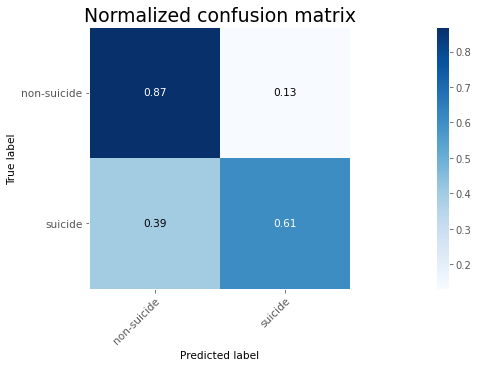

In [ ]:
# Plot confusion matrix.
plot_confusion_matrix(y_true=df['class'][:1000].drop(index=overflow_ids), y_pred=y_pred_gpt3, 
                      classes=list(labels_ids.keys()), normalize=True, 
                      magnify=0.1,
                      );

In [ ]:
start_time = time.time()
overflow_ids_gpt2 = []
i = 0
y_pred_gpt2 = []
for row in df['text'][:1000]:
    print("=== {} ===".format(i))
    try:
        y_pred_gpt2.append(gpt2.ask(row)[0])
    except IndexError:
        overflow_ids_gpt2.append(i)
    finally:
        i += 1
print("--- %s seconds ---" % (time.time() - start_time))

=== 0 ===
=== 1 ===
=== 2 ===
=== 3 ===
=== 4 ===
=== 5 ===
=== 6 ===
=== 7 ===
=== 8 ===
=== 9 ===
=== 10 ===
=== 11 ===
=== 12 ===
=== 13 ===
=== 14 ===
=== 15 ===
=== 16 ===
=== 17 ===
=== 18 ===
=== 19 ===
=== 20 ===
=== 21 ===
=== 22 ===
=== 23 ===
=== 24 ===
=== 25 ===
=== 26 ===
=== 27 ===
=== 28 ===
=== 29 ===
=== 30 ===
=== 31 ===
=== 32 ===
=== 33 ===
=== 34 ===
=== 35 ===
=== 36 ===
=== 37 ===
=== 38 ===
=== 39 ===
=== 40 ===
=== 41 ===
=== 42 ===
=== 43 ===
=== 44 ===
=== 45 ===
=== 46 ===
=== 47 ===
=== 48 ===
=== 49 ===
=== 50 ===
=== 51 ===
=== 52 ===
=== 53 ===
=== 54 ===
=== 55 ===
=== 56 ===
=== 57 ===
=== 58 ===
=== 59 ===
=== 60 ===
=== 61 ===
=== 62 ===
=== 63 ===
=== 64 ===
=== 65 ===
=== 66 ===
=== 67 ===
=== 68 ===
=== 69 ===
=== 70 ===
=== 71 ===
=== 72 ===
=== 73 ===
=== 74 ===
=== 75 ===
=== 76 ===
=== 77 ===
=== 78 ===
=== 79 ===
=== 80 ===
=== 81 ===
=== 82 ===
=== 83 ===
=== 84 ===
=== 85 ===
=== 86 ===
=== 87 ===
=== 88 ===
=== 89 ===
=== 90 ===
=== 91 ==

In [ ]:
print(overflow_ids_gpt2)

[20, 21, 75, 84, 90, 152, 165, 181, 213, 214, 251, 255, 317, 366, 414, 534, 540, 646, 648, 663, 688, 792, 855, 973]


In [ ]:
print(len(y_pred_gpt2))
print(len(overflow_ids_gpt2))

976
24


Normalized confusion matrix


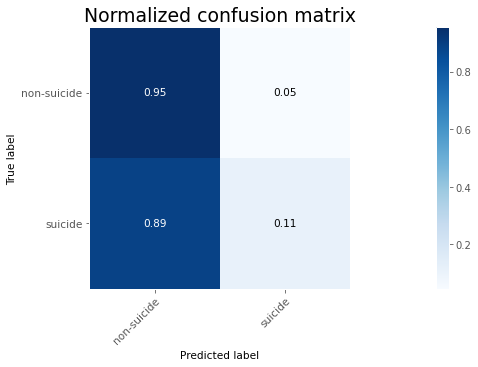

In [ ]:
# Plot confusion matrix.
plot_confusion_matrix(y_true=df['class'][:1000].drop(index=overflow_ids_gpt2), y_pred=y_pred_gpt2, 
                      classes=list(labels_ids.keys()), normalize=True, 
                      magnify=0.1,
                      );

## After finetuning

In [11]:
# Get GPT-2
model_config = GPT2Config.from_pretrained('NoNameForMe/safechat-gpt2', num_labels=2) # Binary Classification
model = GPT2ForSequenceClassification.from_pretrained('NoNameForMe/safechat-gpt2', config=model_config)

tokenizer = GPT2Tokenizer.from_pretrained('NoNameForMe/safechat-gpt2')
tokenizer.padding_side = "left" # Very Important
tokenizer.pad_token = tokenizer.eos_token

model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id

Downloading:   0%|          | 0.00/995 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/510M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/999k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/470 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/748 [00:00<?, ?B/s]

In [13]:
def get_gpt2_result(output):
    if output == 0:
        return 'non-suicide'
    return 'suicide'

def gpt2_pred(prompt):
    inputs = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True, max_length=None)
    return get_gpt2_result(model(**inputs)["logits"].argmax(axis=-1).item())

In [18]:
# Get GPT-3
def get_gpt3_result(text):
    if "non" in text.strip() and "suicide" in text.strip():
        return "non-suicide"
    elif "suicide" in text.strip():
        return "suicide"
    return "non-suicide"

gpt3_pred = lambda prompt: get_gpt3_result(openai.Completion.create(model="ada:ft-university-of-toronto-2022-12-03-23-52-58", prompt=prompt, max_tokens=1, temperature=0)['choices'][0]['text'])

In [15]:
labels_ids = {'non-suicide': 0, 'suicide': 1}

In [23]:
test_df = pd.read_json('final_dataset_suicide_test_10_openai_prepared.jsonl', lines=True)
test_df['completion'] = test_df['completion'].apply(lambda x: x.strip())

In [24]:
test_df

,prompt,completion
0,GoodbyeThere is nothing left. This world is em...,suicide
1,this is truly hell.Why can't I die. I don't se...,suicide
2,"Suicide rates higher among whites - why?Hello,...",suicide
3,"Finally telling my storyFirstly, I apologize f...",suicide
4,Why am I being kept alive?I'm being kept alive...,suicide
...,...,...
4387,Dead in one year if i dont get helpCant go to ...,suicide
4388,She just told me she doesn't care if I hang my...,suicide
4389,i keep waking up at 4 am why cant i fucking sl...,non-suicide
4390,i guess i just need to write this downthis pos...,suicide


In [32]:
len(test_df)

4392

In [26]:
gpt3_pred(test_df['prompt'][0]) == test_df['completion'][0]

True

In [28]:
gpt2_pred(test_df['prompt'][0]) == test_df['completion'][0]

True

In [34]:
gpt2_preds = []
for i in range(len(test_df)):
    pred = gpt2_pred(test_df['prompt'][i])
    gpt2_preds.append(pred)
    print("=== {} pred: {} ===".format(i, pred))

=== 0 pred: suicide ===
=== 1 pred: suicide ===
=== 2 pred: suicide ===
=== 3 pred: suicide ===
=== 4 pred: suicide ===
=== 5 pred: non-suicide ===
=== 6 pred: non-suicide ===
=== 7 pred: suicide ===
=== 8 pred: non-suicide ===
=== 9 pred: suicide ===
=== 10 pred: suicide ===
=== 11 pred: non-suicide ===
=== 12 pred: suicide ===
=== 13 pred: non-suicide ===
=== 14 pred: non-suicide ===
=== 15 pred: suicide ===
=== 16 pred: non-suicide ===
=== 17 pred: non-suicide ===
=== 18 pred: suicide ===
=== 19 pred: non-suicide ===
=== 20 pred: suicide ===
=== 21 pred: suicide ===
=== 22 pred: non-suicide ===
=== 23 pred: suicide ===
=== 24 pred: non-suicide ===
=== 25 pred: non-suicide ===
=== 26 pred: non-suicide ===
=== 27 pred: non-suicide ===
=== 28 pred: suicide ===
=== 29 pred: suicide ===
=== 30 pred: suicide ===
=== 31 pred: non-suicide ===
=== 32 pred: suicide ===
=== 33 pred: non-suicide ===
=== 34 pred: suicide ===
=== 35 pred: suicide ===
=== 36 pred: non-suicide ===
=== 37 pred: non-

In [37]:
with open("gpt2_preds.json", "w") as fp:
    json.dump(gpt2_preds, fp)

Normalized confusion matrix


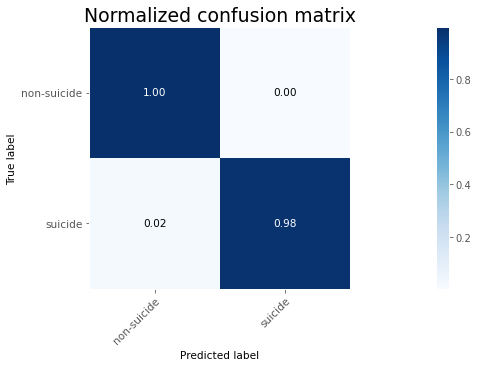

In [38]:
# Plot confusion matrix (gpt2).
plot_confusion_matrix(y_true=test_df['completion'], y_pred=gpt2_preds, 
                      classes=list(labels_ids.keys()), normalize=True, 
                      magnify=0.1,
                      );

In [39]:
# with open("gpt2_preds.json", "r") as fp:
#     gpt2_preds = json.load(fp)

['suicide', 'suicide', 'suicide', 'suicide', 'suicide', 'non-suicide', 'non-suicide', 'suicide', 'non-suicide', 'suicide', 'suicide', 'non-suicide', 'suicide', 'non-suicide', 'non-suicide', 'suicide', 'non-suicide', 'non-suicide', 'suicide', 'non-suicide', 'suicide', 'suicide', 'non-suicide', 'suicide', 'non-suicide', 'non-suicide', 'non-suicide', 'non-suicide', 'suicide', 'suicide', 'suicide', 'non-suicide', 'suicide', 'non-suicide', 'suicide', 'suicide', 'non-suicide', 'non-suicide', 'non-suicide', 'suicide', 'non-suicide', 'non-suicide', 'non-suicide', 'suicide', 'suicide', 'non-suicide', 'suicide', 'non-suicide', 'suicide', 'suicide', 'suicide', 'suicide', 'suicide', 'suicide', 'suicide', 'suicide', 'non-suicide', 'suicide', 'suicide', 'non-suicide', 'non-suicide', 'non-suicide', 'non-suicide', 'non-suicide', 'suicide', 'non-suicide', 'suicide', 'non-suicide', 'suicide', 'suicide', 'suicide', 'suicide', 'suicide', 'suicide', 'suicide', 'non-suicide', 'non-suicide', 'non-suicide', '

In [57]:
gpt3_preds = []
for i in range(len(test_df)):
    seq = test_df['prompt'][i]
    if len(tokenizer.tokenize(seq)) > 2049:
        seq = seq[2045 * 4:] + '\n\n###\n\n'
    pred = gpt3_pred(seq)
    gpt3_preds.append(pred)
    print("=== {} pred: {} ===".format(i, pred))

=== 0 pred: suicide ===
=== 1 pred: suicide ===
=== 2 pred: suicide ===
=== 3 pred: suicide ===
=== 4 pred: suicide ===
=== 5 pred: non-suicide ===
=== 6 pred: non-suicide ===
=== 7 pred: suicide ===
=== 8 pred: non-suicide ===
=== 9 pred: suicide ===
=== 10 pred: suicide ===
=== 11 pred: non-suicide ===
=== 12 pred: suicide ===
=== 13 pred: non-suicide ===
=== 14 pred: non-suicide ===
=== 15 pred: suicide ===
=== 16 pred: non-suicide ===
=== 17 pred: non-suicide ===
=== 18 pred: suicide ===
=== 19 pred: suicide ===
=== 20 pred: suicide ===
=== 21 pred: suicide ===
=== 22 pred: non-suicide ===
=== 23 pred: suicide ===
=== 24 pred: non-suicide ===
=== 25 pred: non-suicide ===
=== 26 pred: non-suicide ===
=== 27 pred: non-suicide ===
=== 28 pred: suicide ===
=== 29 pred: suicide ===
=== 30 pred: suicide ===
=== 31 pred: non-suicide ===
=== 32 pred: suicide ===
=== 33 pred: non-suicide ===
=== 34 pred: suicide ===
=== 35 pred: suicide ===
=== 36 pred: non-suicide ===
=== 37 pred: non-suic

In [58]:
with open("gpt3_preds.json", "w") as fp:
    json.dump(gpt3_preds, fp)

Normalized confusion matrix


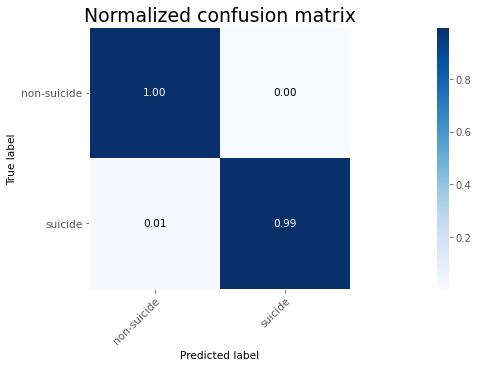

In [59]:
# Plot confusion matrix (gpt3).
plot_confusion_matrix(y_true=test_df['completion'], y_pred=gpt3_preds, 
                      classes=list(labels_ids.keys()), normalize=True, 
                      magnify=0.1,
                      );

In [ ]:
# with open("gpt2_preds.json", "r") as fp:
#     gpt2_preds = json.load(fp)

# with open("gpt3_preds.json", "r") as fp:
#     gpt3_preds = json.load(fp)

In [73]:
print("gpt2 accuracy: ", accuracy_score(y_pred=gpt2_preds, y_true=test_df['completion']))
print("gpt2 precision: ", precision_score(y_pred=gpt2_preds, y_true=test_df['completion'], pos_label='suicide'))
print("gpt2 recall: ", recall_score(y_pred=gpt2_preds, y_true=test_df['completion'], pos_label='suicide'))
print("gpt2 f1: ", f1_score(y_pred=gpt2_preds, y_true=test_df['completion'], pos_label='suicide'))

gpt2 accuracy:  0.9895264116575592
gpt2 precision:  0.9953853253345639
gpt2 recall:  0.9835841313269493
gpt2 f1:  0.9894495412844037


In [74]:
print("gpt3 accuracy: ", accuracy_score(y_pred=gpt3_preds, y_true=test_df['completion']))
print("gpt3 precision: ", precision_score(y_pred=gpt3_preds, y_true=test_df['completion'], pos_label='suicide'))
print("gpt3 recall: ", recall_score(y_pred=gpt3_preds, y_true=test_df['completion'], pos_label='suicide'))
print("gpt3 f1: ", f1_score(y_pred=gpt3_preds, y_true=test_df['completion'], pos_label='suicide'))

gpt3 accuracy:  0.9933970856102003
gpt3 precision:  0.9954212454212454
gpt3 recall:  0.9913360693114455
gpt3 f1:  0.993374457390907
